# Importing The Necessary Dependencies

In [1]:
!pip install tensorflow==2.12.0

!pip install keras_cv==0.5.0
!pip install keras-flops

import tensorflow as tf

# Check TensorFlow and Keras version
tensorflow_version = tf.__version__
keras_version = tf.keras.__version__

print(f"TensorFlow Version: {tensorflow_version}")
print(f"Keras Version: {keras_version}")

from keras import backend as K

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 18.8 MB/s eta 0:00:0000:01


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

TensorFlow Version: 2.12.0
Keras Version: 2.12.0


In [2]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, \
    Conv2D, Add, Activation, Lambda,Conv1D

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [3]:
def CSA(concat1, concat2, kernel_size=7):

    if K.image_data_format() == "channels_first":
        channel1 = concat1.shape[1]
        sa1 = Permute((2, 3, 1))(concat1)
        channel2 = concat2.shape[1]
        sa2 = Permute((2, 3, 1))(concat2)
    else:
        channel1 = concat1.shape[-1]
        sa1 = concat1
        channel2 = concat2.shape[-1]
        sa2 = concat2

    avg_pool1 = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(sa1)
    assert avg_pool1.shape[-1] == 1
    avg_pool2 = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(sa2)
    assert avg_pool2.shape[-1] == 1

    sa = Concatenate(axis=3)([avg_pool1, avg_pool2])
    assert sa.shape[-1] == 2

    sa = Conv2D(filters=1,
                kernel_size=kernel_size,
                strides=1,
                padding='same',
                activation='sigmoid',
                kernel_initializer='he_normal',
                use_bias=False)(sa)  
    assert sa.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        sa = Permute((3, 1, 2))(sa)

    return multiply([concat1, sa])

In [4]:

from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Activation, concatenate
from keras_cv.layers import DropBlock2D
from tensorflow.keras.layers import GroupNormalization,BatchNormalization

def SA_UNet(input_size=(592, 592, 3), block_size=7,rate=0.1,start_neurons=16,lr=1e-3):

    inputs = Input(input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1= BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)



    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)


    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = spatial_attention(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(convm)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])


    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(inputs, output_layer)

    # model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Activation, concatenate
from keras_cv.layers import DropBlock2D
from tensorflow_addons.layers import GroupNormalization

def SA_UNetGN_SiLU(input_size=(592, 592, 3), block_size=7, rate=0.1, start_neurons=16):

    inputs = Input(input_size)

    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(inputs)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1 = GroupNormalization(groups=8)(conv1)
    conv1 = Activation('silu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(conv1)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1 = GroupNormalization(groups=8)(conv1)
    conv1 = Activation('silu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(pool1)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = GroupNormalization(groups=8)(conv2)
    conv2 = Activation('silu')(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(conv2)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = GroupNormalization(groups=8)(conv2)
    conv2 = Activation('silu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(pool2)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = GroupNormalization(groups=8)(conv3)
    conv3 = Activation('silu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(conv3)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = GroupNormalization(groups=8)(conv3)
    conv3 = Activation('silu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    convm = Conv2D(start_neurons * 8, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(pool3)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = GroupNormalization(groups=8)(convm)
    convm = Activation('silu')(convm)
    convm = spatial_attention(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(convm)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = GroupNormalization(groups=8)(convm)
    convm = Activation('silu')(convm)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_normal')(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = GroupNormalization(groups=8)(uconv3)
    uconv3 = Activation('silu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = GroupNormalization(groups=8)(uconv3)
    uconv3 = Activation('silu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_normal')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = GroupNormalization(groups=8)(uconv2)
    uconv2 = Activation('silu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = GroupNormalization(groups=8)(uconv2)
    uconv2 = Activation('silu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_normal')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = GroupNormalization(groups=8)(uconv1)
    uconv1 = Activation('silu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", activation=None, kernel_initializer='he_normal')(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = GroupNormalization(groups=8)(uconv1)
    uconv1 = Activation('silu')(uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None, kernel_initializer='he_normal')(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(inputs, output_layer)
    return model


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Lambda
from keras_cv.layers import DropBlock2D
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf


# 定义 SA_UNetV2 模型
def SA_UNetV2(input_size=(592, 592, 3), block_size=7, rate=0.1, start_neurons=16, lr=1e-3):
    inputs = Input(input_size)

    # 编码器部分
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(inputs)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1 = GroupNormalization(groups=8)(conv1)
    conv1 = Activation('silu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(conv1)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1 = GroupNormalization(groups=8)(conv1)
    conv1 = Activation('silu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(pool1)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = GroupNormalization(groups=8)(conv2)
    conv2 = Activation('silu')(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(conv2)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = GroupNormalization(groups=8)(conv2)
    conv2 = Activation('silu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(start_neurons * 3, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(pool2)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = GroupNormalization(groups=8)(conv3)
    conv3 = Activation('silu')(conv3)
    conv3 = Conv2D(start_neurons * 3, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(conv3)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = GroupNormalization(groups=8)(conv3)
    conv3 = Activation('silu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # 中间层
    convm = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(pool3)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = GroupNormalization(groups=8)(convm)
    convm = Activation('silu')(convm)
    convm = spatial_attention(convm)
    convm = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(convm)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = GroupNormalization(groups=8)(convm)
    convm = Activation('silu')(convm)

    deconv3 = Conv2DTranspose(start_neurons * 3, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, CSA(conv3,deconv3)])
    uconv3 = Conv2D(start_neurons * 3, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = GroupNormalization(groups=8)(uconv3)
    uconv3 = Activation('silu')(uconv3)
    uconv3 = Conv2D(start_neurons * 3, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = GroupNormalization(groups=8)(uconv3)
    uconv3 = Activation('silu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, CSA(conv2,deconv2)])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = GroupNormalization(groups=8)(uconv2)
    uconv2 = Activation('silu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = GroupNormalization(groups=8)(uconv2)
    uconv2 = Activation('silu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, CSA(conv1,deconv1)])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = GroupNormalization(groups=8)(uconv1)
    uconv1 = Activation('silu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same",kernel_initializer='he_normal')(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = GroupNormalization(groups=8)(uconv1)
    uconv1 = Activation('silu')(uconv1)


    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None,kernel_initializer='he_normal')(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(inputs, output_layer)

    return model


In [7]:
import numpy as np

import os
def pad_images(input_data, target_shape):
    # Create an array filled with zeros for padding
    padded_data = np.zeros(target_shape)
    for i in range(input_data.shape[0]):
        # Copy original image into the padded array
        padded_data[i, :input_data.shape[1], :input_data.shape[2], :] = input_data[i]
    return padded_data

def restore_images(output_data, original_shape):
    # Create an array to store restored images
    restored_data = np.zeros(original_shape)
    for i in range(original_shape[0]):
        # Crop the padded image back to original size
        restored_data[i] = output_data[i, :original_shape[1], :original_shape[2], :]
    return restored_data

# Test data
input_data = np.random.rand(20, 584, 565, 3)
target_shape = (20, 592, 592, 3)

# Pad data
padded_data = pad_images(input_data, target_shape)

# Restore original size
restored_data = restore_images(padded_data, input_data.shape)

# Verify whether the original data and restored data are identical
print(np.array_equal(input_data, restored_data))


True


In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
import cv2
from sklearn.metrics import  recall_score, roc_auc_score, accuracy_score, confusion_matrix
from keras.callbacks import  ModelCheckpoint
import imageio
import  math
import os
from keras.optimizers import Adam
data_location = '/kaggle/input/drive-aug/'

training_images_loc = data_location + 'DRIVE/train/images/'
training_label_loc = data_location + 'DRIVE/train/labels/'

validate_images_loc = data_location + 'DRIVE/validate/images/'
validate_label_loc = data_location + 'DRIVE/validate/labels/'
train_files = os.listdir(training_images_loc)
train_data = []
train_label = []
validate_files = os.listdir(validate_images_loc)
validate_data = []
validate_label = []
desired_size=592
for i in train_files:
    im = imageio.imread(training_images_loc + i)
    im_reshaped = np.reshape(im, (1, 584, 565, 3))
    new_im = pad_images(im_reshaped, (1,desired_size,desired_size,3))
    new_im = np.reshape(new_im, (desired_size, desired_size, 3))
    label = imageio.imread(training_label_loc + i.split('_')[0] + '_manual1.png', mode='L')
    label_reshaped = np.reshape(label, (1, 584, 565, 1))
    new_label = pad_images(label_reshaped, (1,desired_size,desired_size,1))
    new_label =  np.reshape(new_label, (desired_size, desired_size, 1))
    train_data.append(cv2.resize(new_im, (desired_size, desired_size)))
    temp = cv2.resize(new_label, (desired_size, desired_size))
    _, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    train_label.append(temp)

for i in validate_files:
    im = imageio.imread(validate_images_loc + i)
    im_reshaped = np.reshape(im, (1, 584, 565, 3))
    new_im = pad_images(im_reshaped, (1,desired_size,desired_size,3))
    new_im = np.reshape(new_im, (desired_size, desired_size, 3))
    label = imageio.imread(validate_label_loc + i.split('_')[0] + '_manual1.png', mode='L')
    label_reshaped = np.reshape(label, (1, 584, 565, 1))
    new_label = pad_images(label_reshaped, (1,desired_size,desired_size,1))
    new_label =  np.reshape(new_label, (desired_size, desired_size, 1))
    validate_data.append(cv2.resize(new_im, (desired_size, desired_size)))
    temp = cv2.resize(new_label, (desired_size, desired_size))
    _, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    validate_label.append(temp)

    


train_data = np.array(train_data)
train_label = np.array(train_label)


validate_data = np.array(validate_data)
validate_label = np.array(validate_label)

x_train = train_data.astype('float32') / 255.
y_train = train_label.astype('float32') / 255.
x_train = np.reshape(x_train, (
len(x_train), desired_size, desired_size, 3))  # adapt this if using `channels_first` image data format
y_train = np.reshape(y_train, (len(y_train), desired_size, desired_size, 1))  # adapt this if using `channels_first` im

x_validate = validate_data.astype('float32') / 255.
y_validate = validate_label.astype('float32') / 255.
x_validate = np.reshape(x_validate, (
len(x_validate), desired_size, desired_size, 3))  # adapt this if using `channels_first` image data format
y_validate = np.reshape(y_validate,
                        (len(y_validate), desired_size, desired_size, 1))  # adapt this if using `channels_first` im

/tmp/ipykernel_34/3268906096.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(training_images_loc + i)
/tmp/ipykernel_34/3268906096.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(training_label_loc + i.split('_')[0] + '_manual1.png', mode='L')
/tmp/ipykernel_34/3268906096.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = i

In [9]:
import tensorflow as tf
from skimage.morphology import skeletonize
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K


def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return loss

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    """Jaccard Loss (Intersection over Union) for binary segmentation."""
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    loss = 1 - (intersection + smooth) / (union + smooth)
    return loss

def ssim_loss(y_true, y_pred):
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return 1 - tf.reduce_mean(ssim)

def gradient_regularizer(y_pred):
    dx = tf.abs(y_pred[:,1:,:,:] - y_pred[:,:-1,:,:])
    dy = tf.abs(y_pred[:,:,1:,:] - y_pred[:,:,:-1,:])
    return tf.reduce_mean(dx) + tf.reduce_mean(dy)



class MCC_Loss(keras.losses.Loss):
    def __init__(self, name="mcc_loss"):
        super(MCC_Loss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        """
        Calculates the Matthews Correlation Coefficient (MCC) loss.
        
        Arguments:
            y_true: Ground truth labels, shape (batch_size, num_classes).
            y_pred: Model predictions (probabilities), shape (batch_size, num_classes).
            
        Returns:
            A scalar value representing the MCC loss.
        """
        # Keep the predictions as continuous probabilities instead of applying a hard threshold
        tp = K.sum(y_pred * y_true)  # True Positives
        tn = K.sum((1 - y_true) * (1 - y_pred))  # True Negatives
        fp = K.sum((1 - y_true) * y_pred)  # False Positives
        fn = K.sum(y_true * (1 - y_pred))  # False Negatives
        
        # Compute MCC using the formula
        numerator = tp * tn - fp * fn
        denominator = K.sqrt(
            (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
        )
        
        # MCC loss: 1 - MCC
        mcc = numerator / (denominator + K.epsilon())  # Adding epsilon to avoid divide by zero
        return 1 - mcc  # We return 1 - MCC because we are minimizing the loss

def combined_loss(y_true, y_pred):
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    jaccard = jaccard_loss(y_true, y_pred)  # 新增的Jaccard Loss
    ssim = ssim_loss(y_true, y_pred)
    smoothness = gradient_regularizer(y_pred)
    mcc = MCC_Loss()(y_true, y_pred) 
    
    return 0.5 * mcc  + 0.5 * bce

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # newly added import
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Create model
model = SA_UNetV2(
    input_size=(592, 592, 3),
    start_neurons=16,
    rate=0.15,
    block_size=7
)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    # loss="binary_crossentropy", # use defined combined loss
    loss=combined_loss,
    metrics=['accuracy']
)

from keras_flops import get_flops
import tensorflow as tf

model.summary()
# Calculate FLOPs (using 1 sample as input, shape = 592x592x3)
flops = get_flops(model, batch_size=1)
print(f"GFLOPs: {flops / 1e9:.3f} GFLOPs")

# model.summary()
weight = "SA_UNetv2.h5"
restore = False

if restore and os.path.isfile(weight):
    model.load_weights(weight)

# Configure callbacks
callbacks = [
    # Save best weights (monitoring validation accuracy)
    ModelCheckpoint(
        weight,
        monitor='val_accuracy',  # you can also use 'val_loss'
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max'  # use max when monitoring accuracy, use min when monitoring loss
    ),
    
    # Dynamic learning rate reduction (monitoring validation loss)
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,       # learning rate reduction factor
        patience=10,      # wait for 10 epochs without improvement
        min_lr=1e-6,      # minimum learning rate
        verbose=1
    ),
    
    # Early stopping mechanism (monitoring validation loss)
    EarlyStopping(
        monitor='val_loss',
        patience=20,      # stop after 20 epochs without improvement
        restore_best_weights=True,  # restore the best weights
        verbose=1
    )
]

# # Start training
# history = model.fit(
#     x_train, y_train,
#     epochs=150,
#     batch_size=8,
#     validation_data=(x_val, y_val),
#     shuffle=True,
#     callbacks=callbacks  # use the configured callback list
# )


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 592, 592, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 592, 592, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 drop_block2d (DropBlock2D)     (None, 592, 592, 16  0           ['conv2d[0][0]']                 
                                )                                                             

/tmp/ipykernel_34/695804225.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(testing_images_loc + i)
/tmp/ipykernel_34/695804225.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(testing_label_loc + i.split('_')[0] + '_manual1.gif')


(20, 584, 565, 3) (20, 584, 565, 1)


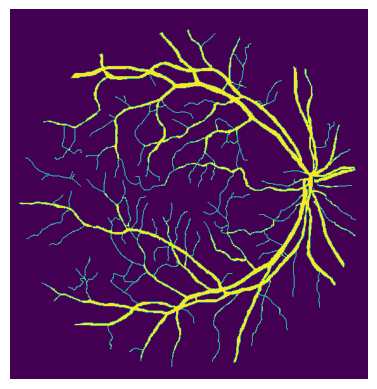

In [11]:
testing_images_loc = '/kaggle/input/drive2004/DRIVE/test/images/'
testing_label_loc = '/kaggle/input/drive2004/DRIVE/test/1st_manual/'

test_files = os.listdir(testing_images_loc)
test_data = []
test_label = []
for i in test_files:
    im = imageio.imread(testing_images_loc + i)
    label = imageio.imread(testing_label_loc + i.split('_')[0] + '_manual1.gif')
    test_data.append(cv2.resize(im, (565, 584)))
    temp = cv2.resize(label, (565, 584))
    _, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    test_label.append(temp)
test_data = np.array(test_data)
test_label = np.array(test_label)
test_label = np.expand_dims(test_label,axis=-1)

x_test = test_data.astype('float32') / 255.
y_test = test_label.astype('float32') / 255.
print(x_test.shape,y_test.shape)
plt.imshow(y_test[0])
plt.axis('off') 
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def pad_images(input_data, target_shape):
    padded_data = np.zeros(target_shape)
    for i in range(input_data.shape[0]):
        # Copy original image into the padded image
        padded_data[i, :input_data.shape[1], :input_data.shape[2], :] = input_data[i]
    return padded_data

def restore_images(output_data, original_shape):
    restored_data = np.zeros(original_shape)
    for i in range(original_shape[0]):
        # Crop padded image back to original size
        restored_data[i] = output_data[i, :original_shape[1], :original_shape[2], :]
    return restored_data

# Test data
input_data = np.random.rand(20, 584, 565, 1)
target_shape = (20, 592, 592, 1)

# Pad data
padded_data = pad_images(input_data, target_shape)

# Restore original size
restored_data = restore_images(padded_data, input_data.shape)

# Verify whether the original data and the restored data are identical
print(np.array_equal(input_data, restored_data))


True


In [13]:
x_test=pad_images(x_test,(20, 592, 592, 3))

3/3 [==============================] - 6s 588ms/step
Inference time: 6.6744 seconds
(20, 592, 592, 1)


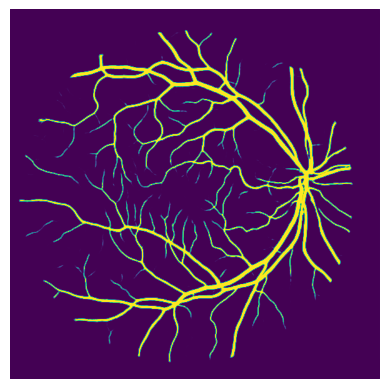

In [14]:
import time

weight = "/kaggle/input/sa-unetv2/SA_UNetv2.h5"

if os.path.isfile(weight):
    model.load_weights(weight)

start_time = time.time()
y_pred = model.predict(x_test, batch_size=8)
end_time = time.time()

print(f"Inference time: {end_time - start_time:.4f} seconds")
print(y_pred.shape)

plt.imshow(y_pred[0])
plt.axis('off')
plt.show()


3/3 [==============================] - 0s 158ms/step
(20, 592, 592, 1)


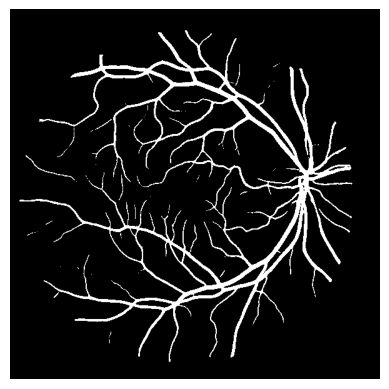

In [15]:
import matplotlib.pyplot as plt

# Load model weights (if available)
if os.path.isfile(weight):
    model.load_weights(weight)

# Prediction
y_pred = model.predict(x_test, batch_size=8)
print(y_pred.shape)

# Binarize prediction (threshold = 0.5)
binary_pred = (y_pred[0, ..., 0] > 0.5).astype('float32')

# Display black-and-white image
plt.imshow(binary_pred, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()


(20, 584, 565, 1)


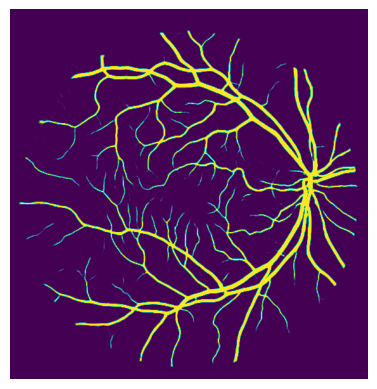

In [16]:
y_pred= restore_images(y_pred,(20,584,565,1))
print(y_pred.shape)
plt.imshow(y_pred[0])
plt.axis('off')  
plt.show()

# Loading and Splitting The Data

In [17]:
import os

save_dir = '/kaggle/working/SAUNetV2/'  # Path of the folder where you want to save files
os.makedirs(save_dir, exist_ok=True)  # Automatically create the directory if it does not exist

groundtruth_dir = '/kaggle/working/groundtruth_dir/'  # Path of the folder for saving ground truth
os.makedirs(save_dir, exist_ok=True)  # Automatically create the directory if it does not exist
os.makedirs(groundtruth_dir, exist_ok=True)  # Automatically create the directory if it does not exist


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score, matthews_corrcoef, f1_score, jaccard_score
import numpy as np
import cv2
import os

os.makedirs(save_dir, exist_ok=True)
os.makedirs(groundtruth_dir, exist_ok=True)

# Initialize lists
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
auc_scores = []
mcc_scores = []
f1_scores = []
jaccard_scores = []

# Iterate through predictions and ground truth labels
for i, (y_pred_image, y_test_image) in enumerate(zip(y_pred, y_test)):
    # ➤ Binarize prediction image
    _, binary_pred = cv2.threshold(y_pred_image, 0.5, 1, cv2.THRESH_BINARY)
    
    # ➤ Flatten to 1D arrays
    y_pred_flat = binary_pred.ravel()
    y_test_flat = y_test_image.ravel()

    # ➤ Compute metrics
    tn, fp, fn, tp = confusion_matrix(y_test_flat, y_pred_flat).ravel()
    accuracy = accuracy_score(y_test_flat, y_pred_flat)
    sensitivity = recall_score(y_test_flat, y_pred_flat)
    specificity = tn / (tn + fp + 1e-6)  # Avoid division by zero
    auc = roc_auc_score(y_test_flat, y_pred_image.ravel())
    mcc = matthews_corrcoef(y_test_flat, y_pred_flat)
    f1 = f1_score(y_test_flat, y_pred_flat)
    jaccard = jaccard_score(y_test_flat, y_pred_flat)

    # ➤ Save metrics
    accuracy_scores.append(accuracy)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    auc_scores.append(auc)
    mcc_scores.append(mcc)
    f1_scores.append(f1)
    jaccard_scores.append(jaccard)

    # ➤ Save prediction and ground truth images (binary images: 0 or 255)
    pred_save = (binary_pred * 255).astype(np.uint8)
    gt_save = (y_test_image * 255).astype(np.uint8)

    cv2.imwrite(os.path.join(save_dir, f'{i}.png'), pred_save)
    cv2.imwrite(os.path.join(groundtruth_dir, f'{i}.png'), gt_save)

# ➤ Print average metrics
print('Average Accuracy:', np.mean(accuracy_scores))
print('Average Sensitivity:', np.mean(sensitivity_scores))
print('Average Specificity:', np.mean(specificity_scores))
print('Average AUC:', np.mean(auc_scores))
print('Average MCC:', np.mean(mcc_scores))
print('Average F1 Score:', np.mean(f1_scores))
print('Average Jaccard Index:', np.mean(jaccard_scores))


Average Accuracy: 0.9697748211904473
Average Sensitivity: 0.8363911656197939
Average Specificity: 0.9828045507500484
Average AUC: 0.9871890264956601
Average MCC: 0.8127267681029036
Average F1 Score: 0.8281796485860925
Average Jaccard Index: 0.7069889620584389


In [19]:
# Import required libraries
import os
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, matthews_corrcoef, f1_score

# Set paths for test images and labels
testing_images_loc = '/kaggle/input/drive2004/DRIVE/test/images/'
testing_label_loc = '/kaggle/input/drive2004/DRIVE/test/1st_manual/'
mask_loc = "/kaggle/input/drive2004/DRIVE/test/mask/"
test_files = os.listdir(testing_images_loc)

# Read test images and labels
test_data = []
test_label = []
mask_label = []
for i in test_files:
    im = imageio.imread(testing_images_loc + i)
    label = imageio.imread(testing_label_loc + i.split('_')[0] + '_manual1.gif')
    mask = imageio.imread(mask_loc + i.split('.')[0] + '_mask.gif')
    mask_label.append(mask)

    test_data.append(cv2.resize(im, (565, 584)))
    temp = cv2.resize(label, (565, 584))
    _, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    test_label.append(temp)


/tmp/ipykernel_34/2458527635.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(testing_images_loc + i)
/tmp/ipykernel_34/2458527635.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(testing_label_loc + i.split('_')[0] + '_manual1.gif')
/tmp/ipykernel_34/2458527635.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imr

In [20]:
test_data = np.array(test_data)
test_label = np.array(test_label)
mask_label = np.array(mask_label)

# test_label = np.expand_dims(test_label, axis=-1)
x_test = test_data.astype('float32') / 255.
y_test = test_label.astype('float32') / 255.
mask = mask_label.astype('float32') / 255.

print(mask.shape)
print(y_test.shape)

print(np.amax(mask))

# Pad images to the specified size


(20, 584, 565)
(20, 584, 565)
1.0


In [21]:
test_gt = []

# Iterate over each 2D array in the mask
for i in range(mask.shape[0]):
    # Find the indices where the mask value is 1
    indices = np.where(mask[i] == 1)
    # Extract the corresponding y_test data using the indices
    extracted_image = y_test[i][indices]
    # Store the extracted data in the list
    test_gt.append(extracted_image)


In [22]:
print(len(test_gt[0]))

227332


In [23]:
x_test = pad_images(x_test, (20, 592, 592, 3))

weight = "/kaggle/input/sa-unetv2/SA_UNetv2.h5"
if os.path.isfile(weight):
    model.load_weights(weight)


y_pred = model.predict(x_test,batch_size=8)
y_pred = restore_images(y_pred, (20, 584, 565, 1))
y_pred = np.squeeze(y_pred)



3/3 [==============================] - 0s 163ms/step


In [24]:
test_pred = []

for i in range(mask.shape[0]):
    # Find the indices where the mask value is 1
    indices = np.where(mask[i] == 1)
    # Extract the corresponding y_pred data using the indices
    extracted_image = y_pred[i][indices]
    # Store the extracted data in the list
    test_pred.append(extracted_image)


In [25]:
for gt, pred in zip(test_gt, test_pred):
    print(len(gt),len(pred))

227332 227332
227394 227394
227388 227388
227693 227693
227499 227499
227612 227612
224377 224377
227500 227500
227675 227675
227694 227694
227577 227577
227523 227523
227814 227814
225248 225248
227660 227660
225884 225884
225087 225087
227605 227605
225854 225854
225727 225727


In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score, matthews_corrcoef, f1_score, jaccard_score
import numpy as np

# Assume test_gt and test_pred are lists containing 20 lists each

# Initialize result lists
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
auc_scores = []
mcc_scores = []
f1_scores = []
jaccard_scores = []

# Iterate through each list and compute metrics
for gt, pred in zip(test_gt, test_pred):
    # Binarize predictions using threshold 0.5
    binary_pred = [(1 if x >= 0.5 else 0) for x in pred]
    
    # Compute confusion matrix values
    tn, fp, fn, tp = confusion_matrix(gt, binary_pred).ravel()
    
    # Compute other metrics
    accuracy = accuracy_score(gt, binary_pred)
    sensitivity = recall_score(gt, binary_pred)
    specificity = tn / (tn + fp)
    auc = roc_auc_score(gt, pred)
    mcc = matthews_corrcoef(gt, binary_pred)
    f1 = f1_score(gt, binary_pred)
    jaccard = jaccard_score(gt, binary_pred)
    
    # Append metrics to result lists
    accuracy_scores.append(accuracy)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    auc_scores.append(auc)
    mcc_scores.append(mcc)
    f1_scores.append(f1)
    jaccard_scores.append(jaccard)

# Compute average or summary results
avg_accuracy = np.mean(accuracy_scores)
avg_sensitivity = np.mean(sensitivity_scores)
avg_specificity = np.mean(specificity_scores)
avg_auc = np.mean(auc_scores)
avg_mcc = np.mean(mcc_scores)
avg_f1 = np.mean(f1_scores)
avg_jaccard = np.mean(jaccard_scores)

# Print results
print('Average Accuracy:', avg_accuracy)
print('Average Sensitivity:', avg_sensitivity)
print('Average Specificity:', avg_specificity)
print('Average AUC:', avg_auc)
print('Average MCC:', avg_mcc)
print('Average F1:', avg_f1)
print('Average Jaccard:', avg_jaccard)


Average Accuracy: 0.9561066888947881
Average Sensitivity: 0.8367066138235707
Average Specificity: 0.9738729246970257
Average AUC: 0.9810741600879785
Average MCC: 0.8044148820949415
Average F1: 0.8283672986847375
Average Jaccard: 0.7072628774755715
